In [1]:
%load_ext autoreload
%autoreload 2
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict, Counter
from experiment_utils import Experiment
from modified_mouselab import TrialSequence
from render_clicks import render_sequence_clicks, render_cluster_sequences
from computational_microscope import ComputationalMicroscope
from learning_utils import pickle_load, pickle_save, get_normalized_features

In [2]:
def get_experiment_strategies(exp_num, block=None):
    path = "results/final_strategy_inferences"
    if block:
        strategies = pickle_load(f"{path}/{exp_num}_{block}_strategies.pkl")
    else:
        strategies = pickle_load(f"{path}/{exp_num}_strategies.pkl")
    return strategies

def print_clusters(cluster_info):
    for cluster in sorted(list(cluster_info.keys())):
        print("\nCluster Number", cluster, "\n")
        for p in cluster_info[cluster]:
            print(p)

def get_ds_weights(weights, features, feature_systems, decision_systems):
    ds_weights = defaultdict(int)
    for (f, w) in zip(features, weights):
        if feature_systems[f] == 'stopping_criteria' or f == "soft_pruning" or f == "termination_constant" or f=="is_previous_successor_negative":
            ds_weights[feature_systems[f]] += -w
        else:
            ds_weights[feature_systems[f]] += w
    return np.array([ds_weights[ds] for ds in decision_systems])

def get_W_DS(W, feature_systems, decision_systems):
    num_strategies = W.shape[0]
    W_DS = []
    for i in range(num_strategies):
        W_DS.append(get_ds_weights(W[i], features, feature_systems, decision_systems))
    W_DS = np.array(W_DS)
    return W_DS

def get_ds_proportions(W_DS):
    DS_proportions = np.zeros_like(W_DS)
    for i in range(DS_proportions.shape[0]):
        total_w = np.sum([abs(w) for w in W_DS[i]])
        if total_w != 0:
            DS_proportions[i] = abs(W_DS[i])/total_w
    return DS_proportions

### Number of clusters vs Log-likelihood

In [3]:
exp_num = "v1.0"
num_participants = 60
cluster_info = {}
log_likelihoods = {}
for k in range(2, 30):
    try:
        cluster_info[k], log_likelihoods[k] = pickle_load(f"results/em_clustering_results/{exp_num}/{k}_{num_participants}.pkl")
    except:
        continue

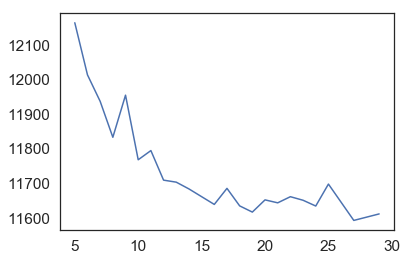

In [4]:
cluster_indices = sorted(list(log_likelihoods.keys()))
sorted_negative_log_likelihoods = [-log_likelihoods[k] for k in cluster_indices]
plt.plot(cluster_indices, sorted_negative_log_likelihoods)

In [5]:
features = pickle_load("data/em_features.pkl")
num_features = len(features)
exp_reward_structures = pickle_load("data/exp_reward_structures.pkl")
normalized_features = get_normalized_features(exp_reward_structures[exp_num])
exp_pipelines = pickle_load("data/exp_pipelines.pkl")
pipeline = [exp_pipelines[exp_num][0]]*1000
decision_systems = pickle_load("data/decision_systems.pkl")
feature_systems = pickle_load("data/feature_systems.pkl")

In [6]:
chosen_k = 10
cluster_info, log_likelihood = pickle_load(f"results/em_clustering_results/{exp_num}/{chosen_k}_{num_participants}.pkl")
W, _, _ = pickle_load(f"results/em_clustering_results/{exp_num}/{chosen_k}_{num_participants}_params.pkl")
#plot_clusters(res, pipeline, f"results/trial_render/{exp_num}")

In [7]:
print_clusters(cluster_info)


Cluster Number 0 

[[0.0, 2, -4, 24, 24, -4, 4, -24, -24, -2, 4, -24, -48], [7, 8, 11, 12, 4, 3, 0], (0, 3)]
[[0.0, -2, 8, 24, -48, 2, 4, -24, 24, -2, -8, 48, -24], [3, 4, 11, 12, 7, 8, 0], (0, 6)]
[[0.0, 2, 8, 48, -24, -4, -4, -48, 24, -4, -8, -48, -24], [3, 4, 12, 11, 7, 8, 0], (0, 9)]
[[0.0, 4, 8, -24, -24, -4, -8, -48, 48, 2, -8, -24, -48], [3, 4, 11, 12, 7, 8, 0], (0, 10)]
[[0.0, 2, 4, -24, 24, 4, 8, -48, -48, -4, -4, -48, -24], [3, 4, 11, 12, 7, 8, 0], (0, 11)]
[[0.0, 2, 8, -48, -24, 2, 8, -24, -48, 4, -4, 24, -48], [12, 11, 4, 3, 7, 8, 0], (0, 12)]
[[0.0, -4, -8, 24, -24, -2, 8, 24, 48, 4, -4, 24, -48], [3, 4, 11, 12, 7, 8, 0], (0, 13)]
[[0.0, 2, 8, 24, -24, 2, -8, -24, -24, 4, -8, 48, 48], [4, 3, 7, 8, 11, 12, 0], (0, 17)]
[[0.0, 4, 4, 48, -48, -2, -8, 48, -24, -4, -8, 24, -48], [4, 3, 0], (0, 20)]
[[0.0, -2, -8, -24, -24, 4, 8, 48, 24, -2, 8, -24, -48], [3, 11, 12, 4, 7, 0], (0, 22)]
[[0.0, 2, 8, 48, 24, -2, 4, 24, 24, -2, -4, -48, -24], [4, 3, 0], (0, 23)]
[[0.0, 4, -8, -48,

### Inferring strategies using the learnt strategies

In [8]:
num_strategies = W.shape[0]
num_evals = 30
strategy_space = list(range(1, num_strategies + 1))
cm = ComputationalMicroscope(pipeline, strategy_space, W, features, normalized_features)
block = None
if block:
    E = Experiment(exp_num, cm=cm, block=block)
else:
    E = Experiment(exp_num, cm=cm)

In [9]:
E.infer_strategies(max_evals=num_evals)

0
0
100%|██████████| 30/30 [00:13<00:00,  2.16it/s, best loss: 239.57615802400505]
[3, 5, 10, 9, 9, 9, 9, 9, 9, 9, 1, 1, 1, 1, 9, 9, 9, 9, 9, 9, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
[3, 5, 10, 9, 9, 9, 9, 9, 9, 9, 1, 1, 1, 1, 9, 9, 9, 9, 9, 9, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1] 0.823971802750033
1
100%|██████████| 30/30 [00:12<00:00,  2.47it/s, best loss: 225.90714005068517]
[5, 5, 5, 5, 5, 5, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 1, 1]
[5, 5, 5, 5, 5, 5, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 1, 1] 0.7507871528745933
2
100%|██████████| 30/30 [00:06<00:00,  4.27it/s, best loss: 98.68618916817621] 
[6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6]
[6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6] 1.5224955724700273
3
100%|██████████| 30/30 [00:08<00:00,  3.82it/s, best loss: 133.5969193673313]
[6, 6, 6, 6, 6, 6, 6, 6, 6,

100%|██████████| 30/30 [00:06<00:00,  4.44it/s, best loss: 109.57578458756126]
[6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4]
[6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4] 1
31
100%|██████████| 30/30 [00:10<00:00,  3.06it/s, best loss: 263.18781990645476]
[4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4]
[4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4] 1.830653107627
32
100%|██████████| 30/30 [00:10<00:00,  2.89it/s, best loss: 171.48784725727822]
[10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10]
[10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10] 0.6837347194948116
33
100%|██████████| 30/30 [00:09<00:00,  3.38it/s, best loss: 166.92546785598478]
[8, 8, 4, 4, 4, 4, 4, 4, 4, 1, 1,

100%|██████████| 30/30 [00:08<00:00,  3.68it/s, best loss: 153.5234067298185] 
[6, 6, 6, 6, 6, 6, 6, 6, 6, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 9, 9, 1, 1, 1, 1, 1]
[6, 6, 6, 6, 6, 6, 6, 6, 6, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 9, 9, 1, 1, 1, 1, 1] 0.9837015574223933
61
100%|██████████| 30/30 [00:08<00:00,  3.59it/s, best loss: 111.71622283897739]
[6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6]
[6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6] 1.3278687227667436
62
100%|██████████| 30/30 [00:16<00:00,  1.78it/s, best loss: 401.54739717405437]
[7, 3, 3, 3, 8, 8, 8, 8, 8, 8, 8, 8, 3, 9, 9, 9, 8, 8, 8, 8, 9, 9, 8, 8, 8, 8, 8, 8, 8, 8]
[7, 3, 3, 3, 8, 8, 8, 8, 8, 8, 8, 8, 3, 9, 9, 9, 8, 8, 8, 8, 9, 9, 8, 8, 8, 8, 8, 8, 8, 8] 1
63
100%|██████████| 30/30 [00:09<00:00,  3.32it/s, best loss: 177.30239698318096]
[9, 9, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 9, 1, 1, 1, 1, 1, 1

100%|██████████| 30/30 [00:07<00:00,  3.69it/s, best loss: 133.49862133866867]
[6, 6, 6, 6, 6, 6, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4]
[6, 6, 6, 6, 6, 6, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4] 1
91
100%|██████████| 30/30 [00:11<00:00,  2.66it/s, best loss: 246.13160920591676]
[10, 10, 7, 7, 5, 5, 7, 4, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 4, 4, 4]
[10, 10, 7, 7, 5, 5, 7, 4, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 4, 4, 4] 1.2056683228906628
92
100%|██████████| 30/30 [00:08<00:00,  3.70it/s, best loss: 147.89646826162948]
[10, 10, 10, 10, 10, 10, 10, 10, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4]
[10, 10, 10, 10, 10, 10, 10, 10, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4] 1
93
100%|██████████| 30/30 [00:14<00:00,  2.08it/s, best loss: 421.4145187773511] 
[6, 10, 4, 4, 4, 5, 2, 2, 4, 5, 7, 8, 8, 8, 8, 9, 2, 2, 2, 8, 7, 8, 8, 8, 8, 8, 8, 9, 

100%|██████████| 30/30 [00:10<00:00,  2.95it/s, best loss: 177.5576326817369] 
[6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 5, 7, 7, 7, 2, 2]
[6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 5, 7, 7, 7, 2, 2] 0.7920561344818167
123
100%|██████████| 30/30 [00:08<00:00,  3.49it/s, best loss: 191.3960242241062] 
[8, 8, 8, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4]
[8, 8, 8, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4] 1.2896084670956582
124
100%|██████████| 30/30 [00:16<00:00,  1.76it/s, best loss: 411.86078805547584]
[10, 5, 5, 5, 5, 5, 5, 2, 2, 2, 7, 5, 5, 7, 7, 5, 5, 5, 5, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7]
[10, 5, 5, 5, 5, 5, 5, 2, 2, 2, 7, 5, 5, 7, 7, 5, 5, 5, 5, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7] 1.256756220146988
125
100%|██████████| 30/30 [00:09<00:00,  3.29it/s, best loss: 124.17509698938795]
[10, 10, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 9, 1, 1, 1, 1, 1, 1,

100%|██████████| 30/30 [00:10<00:00,  3.01it/s, best loss: 160.82190584309032]
[10, 10, 10, 10, 10, 10, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
[10, 10, 10, 10, 10, 10, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1] 1
156
100%|██████████| 30/30 [00:09<00:00,  3.22it/s, best loss: 131.8439032457916]
[6, 6, 6, 6, 6, 5, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
[6, 6, 6, 6, 6, 5, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1] 1
157
100%|██████████| 30/30 [00:08<00:00,  3.66it/s, best loss: 143.36698282515084]
[6, 6, 6, 4, 4, 4, 4, 4, 4, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 8, 8, 8, 8, 8, 8]
[6, 6, 6, 4, 4, 4, 4, 4, 4, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 8, 8, 8, 8, 8, 8] 1
158
100%|██████████| 30/30 [00:05<00:00,  5.87it/s, best loss: 2.302585092994046]
[6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6]
[6, 6, 6, 6, 6, 6, 

UnboundLocalError: local variable 'S' referenced before assignment

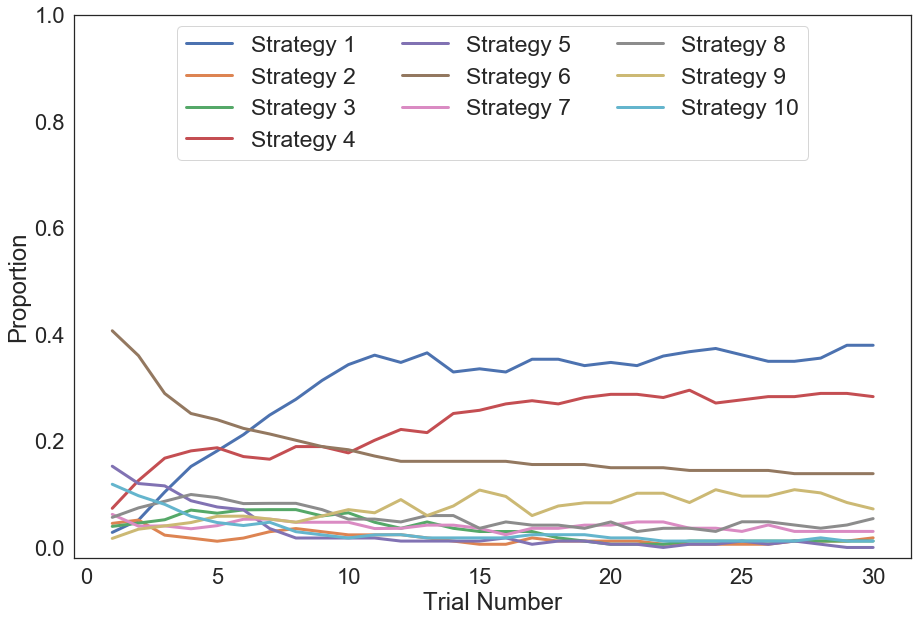

In [10]:
E.plot_strategy_proportions(S=list(range(1, num_strategies+1)))

In [11]:
W_DS = get_W_DS(W, feature_systems, decision_systems)
DS_proportions = get_ds_proportions(W_DS)

In [15]:
E.init_decision_system_properties(decision_systems, W_DS, DS_proportions)

TypeError: 'NoneType' object is not iterable

In [16]:
E.plot_average_ds()

AttributeError: 'Participant' object has no attribute 'decision_system_proportions'

### Comparing it to the manual set of strategies

In [17]:
strategies = get_experiment_strategies(exp_num, block=block)
if block:
    E2 = Experiment(exp_num, block=block)
else:
    E2 = Experiment(exp_num)
E2.infer_strategies(precomputed_strategies=strategies, show_pids=False)

Strategies for 94 not found. Skipping adding strategy data
Strategies for 103 not found. Skipping adding strategy data
Strategies for 128 not found. Skipping adding strategy data
Strategies for 138 not found. Skipping adding strategy data


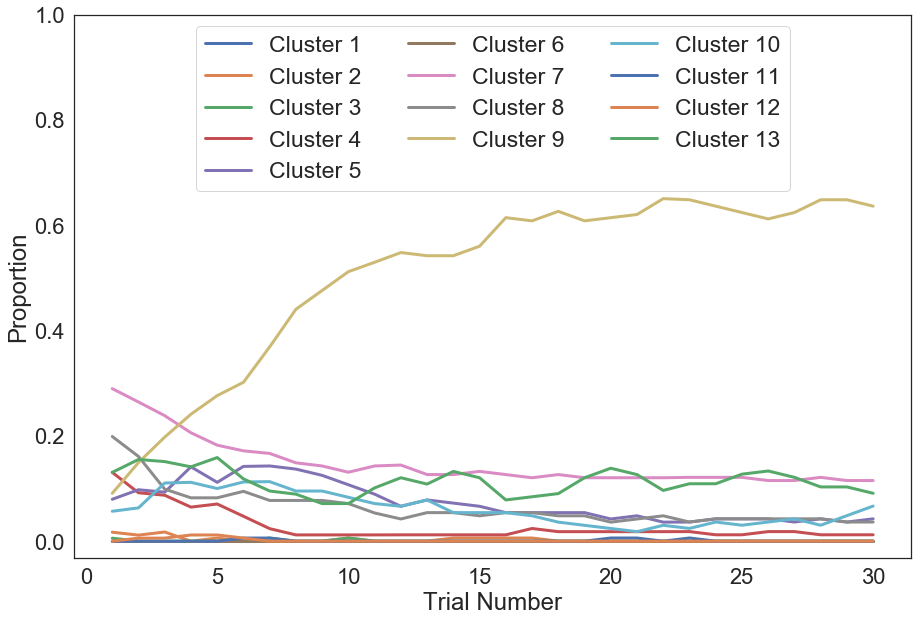

In [18]:
#S = E2.get_top_k_strategies(k=W.shape[0]//2)
#E2.plot_strategy_proportions(S)
manual_cluster_map = pickle_load("data/kl_cluster_map.pkl")
E2.init_strategy_clusters(manual_cluster_map)
E2.plot_cluster_proportions(C = list(range(1, 14)))

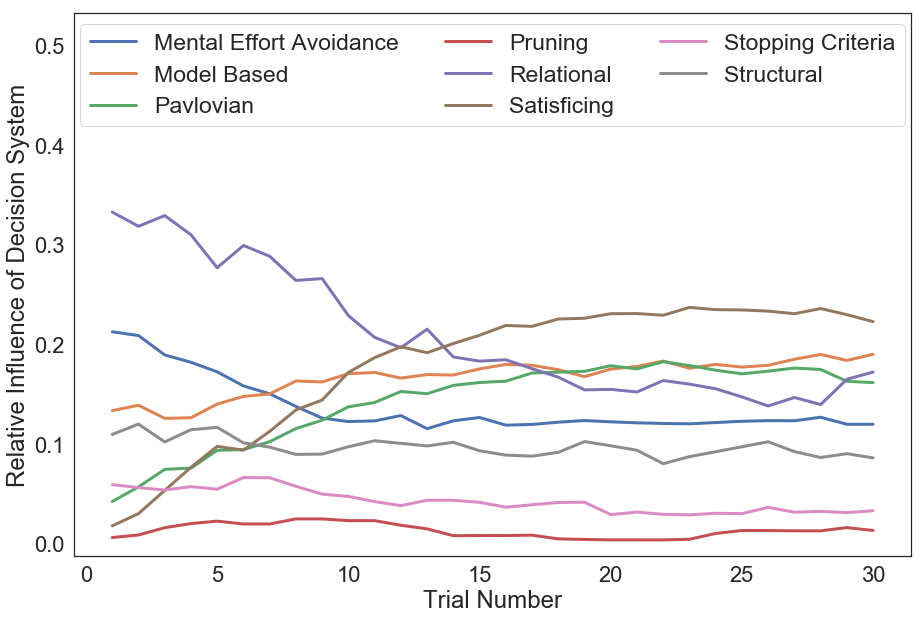

In [20]:
W_DS = pickle_load("data/strategy_decision_weights.pkl")
DS_proportions = pickle_load("data/strategy_decision_proportions.pkl")
E2.init_decision_system_properties(decision_systems, W_DS, DS_proportions)
E2.plot_average_ds()

### Automatic clusters vs manual clusters

In [79]:
automatic_strategies = E.participant_strategies
manual_strategies = E2.participant_strategies

In [81]:
cluster_strategies = defaultdict(list)
for pid in E.pids:
    if pid in manual_strategies:
        for a, m in zip(automatic_strategies[pid], manual_strategies[pid]):
            cluster_strategies[a].append(cluster_map[m])
for k in cluster_strategies.keys():
    cluster_strategies[k] = Counter(cluster_strategies[k])
for k in sorted(list(cluster_strategies.keys())):
    print(k, cluster_strategies[k])

1 Counter({9: 1345, 13: 47, 10: 27, 5: 6, 7: 2, 11: 2, 8: 1})
2 Counter({13: 55, 5: 24, 7: 10, 9: 9, 3: 2, 2: 1, 10: 1})
3 Counter({5: 149, 4: 10, 10: 5, 13: 1})
4 Counter({9: 1023, 10: 126, 13: 26, 12: 4, 8: 3, 7: 1, 5: 1})
5 Counter({4: 89, 8: 17, 5: 15, 13: 12, 2: 9, 3: 1, 7: 1})
6 Counter({7: 698, 8: 221, 4: 9, 13: 8, 9: 3, 10: 3})
7 Counter({5: 140, 4: 27, 10: 15, 8: 8, 2: 4, 13: 3})
8 Counter({10: 113, 13: 107, 9: 31, 5: 19, 7: 3, 12: 3, 8: 2})
9 Counter({13: 279, 9: 112, 5: 7, 10: 6, 11: 2})
10 Counter({8: 73, 13: 31, 7: 27, 5: 11, 4: 10, 10: 10, 9: 6, 11: 1})
